In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import datetime
from os import listdir
from os.path import isfile, join
import matplotlib.dates as mdates
import datetime

import argparse
import configparser
import getpass
import logging
import json
import requests

from myfitbit import Fitbit, FitbitAuth
from myfitbit.export import FitbitExport

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython.display import display


%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 50)
sns.set_context('talk')
sns.set_palette('husl')
sns.set_style('darkgrid')


In [2]:
def download_fitbit_data():
    config = configparser.ConfigParser()
    config.read('myfitbit.ini')

    fa = FitbitAuth(
        client_id=config['fitbit_auth']['client_id'],
        client_secret=config['fitbit_auth']['client_secret'],
    )
    fa.ensure_access_token()

    try:
        f = Fitbit(access_token=fa.access_token['access_token'])
#         print(json.dumps(f.profile, indent=2))
    except requests.exceptions.HTTPError as e:
#         print(e.response.status_code)
        if e.response.status_code == 429:
#             print(e.response.headers)
            return
        raise

    export = FitbitExport('.', f)

    export.sync_sleep()
#     export.sync_heartrate_intraday()
    

def minutesToSleep(data):
    first_stage = pd.DataFrame.from_records(data).sort_values('dateTime').iloc[0]
    if first_stage['level']=='wake':
        minutesToSleep = first_stage['seconds']/60
    else:
        minutesToSleep = 0
    
    return(minutesToSleep)


def minutesToRise(data):
    first_stage = pd.DataFrame.from_records(data).sort_values('dateTime').iloc[-1]
    if first_stage['level']=='wake':
        minutesToRise = first_stage['seconds']/60
    else:
        minutesToRise = 0
    
    return(minutesToRise)

def time2fraction(x):
    x = x.hour + x.minute/60
    if x < 12:
        return x+24
    else: 
        return x

In [3]:
_ = download_fitbit_data()

mypath='/Users/rbloom/git-personal/RubyQS/5HYG9W/sleep/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'json' in f]
df = pd.concat([pd.read_json(join(mypath, f), convert_dates=['startTime', 'endTime', 'dateOfSleep']) for f in onlyfiles])

df['minutesInBed'] = df['timeInBed']
df['hoursInBed'] = (df['minutesInBed']/60).round(1)
df['hoursAsleep'] = (df['minutesAsleep']/60).round(1)
df['minutesToFallAsleep'] = df['levels'].str['data'].apply(minutesToSleep)
df['minutesToRise'] = df['levels'].str['data'].apply(minutesToRise)

df['sleepTime'] = df['startTime'] + pd.to_timedelta(df['minutesToFallAsleep'], unit='m')
df['wakeTime'] = df['endTime'] - pd.to_timedelta(df['minutesToRise'], unit='m')
df['nap'] = (df['hoursAsleep'] < 5)&(df['startTime'].dt.hour<20)&(df['startTime'].dt.hour>=10)

df = df[['dateOfSleep', 'startTime', 'endTime', 'sleepTime', 'wakeTime', 'hoursInBed', 'hoursAsleep', 'minutesInBed', 'minutesAsleep', 'minutesAwake',
        'minutesToFallAsleep', 'minutesToRise', 'levels', 'type', 'nap']]

df = df.sort_values('dateOfSleep')
df_master = df.copy()

stages =  df['levels'].str['summary'].apply(lambda stages: pd.Series(({k:v['minutes'] for k,v in stages.items()})))
stages = stages[['wake', 'rem', 'light', 'deep', 'awake', 'restless', 'asleep']]
df = pd.concat([df_master.copy(), stages], axis=1)

df['dateOfSleep'] = df['dateOfSleep'] + pd.Timedelta('-1 day')
df = df.set_index('dateOfSleep').sort_index()

In [4]:
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

In [5]:
print("""The me who can shape himself fully, who can design his behavior to be optimal, who can actually prioritize the long-term over the immediate - he will be the most satisfied of all the versions of me. He is the one who will most accomplish the most of our values. He will actually be the happiest (even if it is hard to get there). Even the me who tries and fails will have a happiness over the me who does not. I am a pattern who sees what is possible and pursues it. I am not the happiest at complete rest. I’d rather rest in motion.
        \n\nI think I should be able to make it so that doing the ideal behaviors feels more rewarding than pleasure in the moment. I guess the goal is this becomes really ingrained. That I see the choice between sticking to the plan and having my marshmallow now. That I am repulsed by the thought of sacrificing what could be for a marshmallow now.""")

The me who can shape himself fully, who can design his behavior to be optimal, who can actually prioritize the long-term over the immediate - he will be the most satisfied of all the versions of me. He is the one who will most accomplish the most of our values. He will actually be the happiest (even if it is hard to get there). Even the me who tries and fails will have a happiness over the me who does not. I am a pattern who sees what is possible and pursues it. I am not the happiest at complete rest. I’d rather rest in motion.
        

I think I should be able to make it so that doing the ideal behaviors feels more rewarding than pleasure in the moment. I guess the goal is this becomes really ingrained. That I see the choice between sticking to the plan and having my marshmallow now. That I am repulsed by the thought of sacrificing what could be for a marshmallow now.


In [6]:
def data2dd(data):
    dd = data.copy()
    dd['sleep_error'] = (dd['sleepTime'].apply(time2fraction) - 23).round(2)
    dd['wake_error'] = (dd['wakeTime'].apply(time2fraction) - 32).round(2)
    dd['sleepTime'] = dd['sleepTime'].dt.time
    dd['endTime'] = dd['endTime'].dt.time
    dd['wakeTime'] = dd['wakeTime'].dt.time
    dd['day'] = dd.index.to_series().dt.weekday_name.str[0:3]
    return dd

# dd.sort_index(ascending=False)[['day', 'sleepTime', 'wakeTime', 'hoursInBed', 'hoursAsleep', 'sleep_error', 'deep', 'rem', 'wake']]

In [7]:
def consolidate_night_sleeps(data):
    def combine_levels(levels):
        return {'data': [y for x in levels.str['data'].tolist() for y in x]}

    combine_levels(data.tail(2)['levels'])

    def set_sleep_type(types):
        if types.nunique()==1:
            return types.min()
        else: 
            return 'mixed'
        
    consolidated_sleeps =  data.sort_values('sleepTime').groupby(level=0).agg(
                            {'startTime':'min', 'endTime':'max', 'sleepTime': 'min', 'wakeTime':'max',
                              'hoursInBed':'sum', 'hoursAsleep':'sum', 'minutesInBed':'sum', 'minutesAsleep':'sum', 'minutesAwake': 'sum',
                              'minutesToFallAsleep':'first', 'minutesToRise':'last', 'levels': combine_levels, 'type': set_sleep_type, 'nap': (lambda x: False), 
                                'wake': 'sum', 'rem': 'sum', 'light': 'sum', 'deep': 'sum', 'awake': 'sum', 'restless': 'sum', 'asleep': 'sum'}
                                                             )
    
    total_wake = consolidated_sleeps[['wake', 'awake', 'restless']].sum(axis=1)
    consolidated_sleeps['wake'] = total_wake
    consolidated_sleeps['awake'] = total_wake
    

    return consolidated_sleeps

def reindex_sleeps(data):
    idx = pd.date_range(data.index.min(), data.index.max())
    return data.reindex(idx)

def process_sleeps(data):
    return reindex_sleeps(consolidate_night_sleeps(data))

# data2 = process_sleeps(data)
# data2

In [8]:
def stages_plot_line(data, figsize=(20,5), stages=['deep', 'light', 'rem'], color=['#144BA6', '#3F8DFF', '#7EC4FF', '#E73360'], xlabels=True, kind='line'):
    plt.figure(figsize=figsize)
#     ax = (data[['deep', 'light', 'rem', 'wake']]/60).plot.bar(figsize=figsize, stacked=True, color=['#144BA6', '#3F8DFF', '#7EC4FF', '#E73360'], legend=False)
    ax = (data[stages]/60).plot(figsize=figsize, subplots=False, color=color, legend=True, kind=kind)
    _ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: float(x)))
    plt.ylabel('Hours')
    plt.xlabel('')
    plt.legend(loc='upper left')
    if xlabels:
        plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(data.index.to_series().dt.strftime("%m-%d %a")))
    else:
        plt.tick_params(axis='x', labelbottom=False)
    
    return ax

def stages_plot_line_normalized(data, figsize=(20,5), xlabels=True):
    dd = data[['deep', 'rem', 'light', 'wake']]
    dd = dd.div(dd.sum(axis=1),axis=0)
    dd = dd[['deep', 'rem', 'wake']]
    ax = dd.plot(figsize=figsize, color=['#144BA6', '#7EC4FF', '#E73360'], legend=False)
    plt.ylim([0,0.3])
    plt.ylabel('%')
    plt.xlabel('')
    if xlabels:
        pass
#         plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(data.index.to_series().dt.strftime("%m-%d %a")))
    else:
        plt.tick_params(axis='x', labelbottom=False)
    
    return ax

def total_asleep_awake_plot(data, figsize=(20,5),
                color=['blue', '#E7336040'], xlabels=True, kind='bar', legend=False):
    plt.figure(figsize=figsize)
    ax = (data[['minutesAsleep', 'minutesAwake']]/60).plot.bar(figsize=figsize, color=color, legend=legend, stacked=True, width=0.75)
    ax.axhline(y=7.5, xmin=0, xmax=20, linestyle='--', color='black', linewidth=2)
    
    _ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: '{:4.2f}'.format(x)))
        
    if xlabels:
        plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(data.index.to_series().dt.strftime("%m-%d %a")))
    else:
        plt.tick_params(axis='x', labelbottom=False)
    
    plt.ylabel('Hours')
    
    return ax

# _ = total_asleep_awake_plot(data2, (plot_width, 4), xlabels=False)

In [9]:
def stages_plot(data, figsize=(20,5), stages=['light', 'rem', 'deep', 'wake'], 
                color=['#3F8DFF', '#7EC4FF','#144BA6', '#E73360'], xlabels=True, kind='bar', subplots=True, legend=False, width=0.75):
    plt.figure(figsize=figsize)
    axes = (data[stages]/60).plot(figsize=figsize, color=color, legend=legend, kind=kind, subplots=subplots, width=width)
    
    plt.xlabel('')
    axes[2].set_ylabel('                            Hours')
    _ = [ax.set_title('') for ax in axes]
    plt.legend(loc='upper left')
    
    axes[0].set_ylabel('light') 
    axes[1].set_ylabel('rem') 
    axes[2].set_ylabel('deep') 
    axes[3].set_ylabel('wake') 
    
    axes[0].set_ylim([0, 6]) 
    axes[1].set_ylim([0, 2]) 
    axes[2].set_ylim([0, 2]) 
    axes[3].set_ylim([0, 3]) 
    axes[3].get_legend().remove()
    
    for ax in axes:
        _ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: '{:4.2f}'.format(x)))
        
    if not xlabels:
        plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(data.index.to_series().dt.strftime("%m-%d %a")))
    else:
        plt.tick_params(axis='x', labelbottom=False)
    
    
    return ax

# _ = stages_plot(data2, (plot_width, 10), xlabels=False)

In [10]:
def sleep_error_plot(data, figsize=(20,5)):
    data['sleep_error'] = (data['sleepTime'].apply(time2fraction) - 23).round(2)
    data['wake_error'] = (data['wakeTime'].apply(time2fraction) - 32).round(2)
    dd = data[['sleep_error', 'wake_error']].copy()
#     print(dd)
#     dd[dd<0] = 0
    ax = dd.plot.bar(figsize=figsize, stacked=True, color=['red', 'lightblue'], width=0.9) #, color=['red', 'pink'])
    _ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: '{:4.2f}'.format(x)))
    ax.axhline(y=0.25, xmin=0, xmax=20, linestyle='--', color='black', linewidth=2)
    ax.axhline(y=-0.25, xmin=0, xmax=20, linestyle='--', color='black', linewidth=2)
    plt.ylim([-1, np.min([data[['sleep_error', 'wake_error']].sum(axis=1).max(),3])])
    plt.ylabel('Hours')
    plt.xlabel('')
#     plt.legend(['15 mins', 'sleep_late', 'wake_late'])
    
    plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(data.index.to_series().dt.strftime("%m-%d %a")))
    
    
    return ax

In [11]:
stage_colors = {'deep':'#144BA6', 'light':'#3F8DFF', 'rem':'#7EC4FF', 'wake':'#E73360',
                'unknown':'k', 'restless': '#E73360', 'awake': '#E73360', 'asleep': '#3F8DFF'}

green_red_colors = {l: '#E73360' if l in ['wake', 'awake', 'restless'] else 'green' 
                    for l in ['wake', 'deep', 'unknown', 'rem', 'light', 'awake', 'restless', 'asleep']}
# green_red_colors

In [12]:
def stage_process(stage_data):
    def calc_date_of_sleep(startTime):
        if startTime.hour < 12:
            return startTime.date() - pd.Timedelta('1 days')
        else: 
            return startTime.date()
    
    ss = pd.DataFrame.from_records(stage_data).sort_values('dateTime')
    ss['startTime'] = pd.to_datetime(ss['dateTime'])
    ss['dateOfSleep'] = calc_date_of_sleep(ss['startTime'].min()) #.date()
    ss['date_day'] = ss['startTime'].min().strftime("%Y-%m-%d %a")
    ss['endTime'] = (ss['startTime'] + pd.to_timedelta(ss['seconds'], unit='s')).apply(time2fraction)
    ss['startTime'] = ss['startTime'].apply(time2fraction)
    return ss

def stages_column_plot(s, ax, color_dict = stage_colors):
    _ = ax.vlines(s['dateOfSleep'],ymin=s['startTime'], ymax=s['endTime'], linewidth=16 , color=color_dict[s['level']])
    
def stage_data_column_plot(stage_data, ax, color_dict):
    ss = stage_process(stage_data)
    _ = ss.apply(lambda s: stages_column_plot(s, ax, color_dict), axis=1)

def sleep_inspection_plot(data, figsize, xlabels=True):
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    _ = data['levels'].dropna().str['data'].apply(stage_data_column_plot, ax=ax, color_dict=green_red_colors)
    ax.axhline(y=23, xmin=0, xmax=20, linestyle='--', color='k', linewidth=2)
    ax.axhline(y=32, xmin=0, xmax=20, linestyle='--', color='k', linewidth=2)
    

    plt.title('Sleep Inspection Graph', fontweight='bold')
    _ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, y: x%24))
    plt.ylim([21, 34])
    plt.ylabel('Time (24h)')
    
    plt.xticks(rotation=90)
    plt.xlim([data.index[0]-pd.Timedelta('12 hours'), data.index[-1]+pd.Timedelta('12 hours')])
    plt.xlabel('')
    plt.xticks(data.index)
    plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(data.index.to_series().dt.strftime("%m-%d %a")))
    
    if not xlabels:
        plt.tick_params(axis='x', labelbottom=False)
    
    return plt.gca()

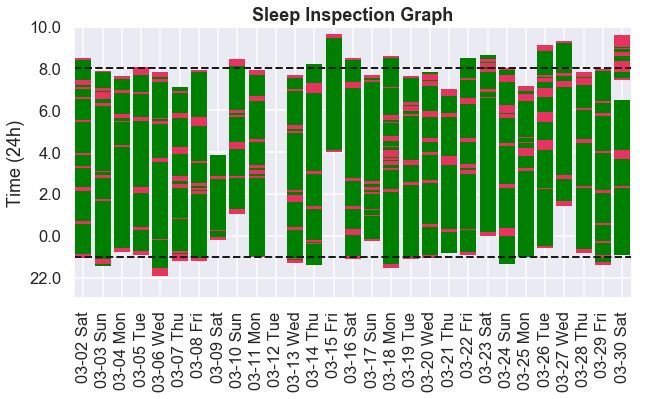

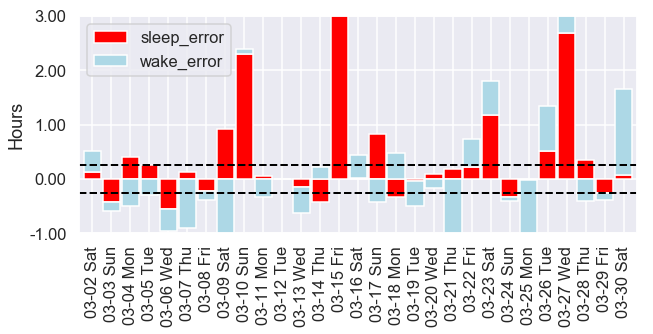

<Figure size 720x216 with 0 Axes>

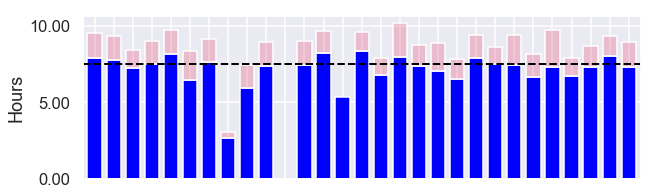

<Figure size 720x720 with 0 Axes>

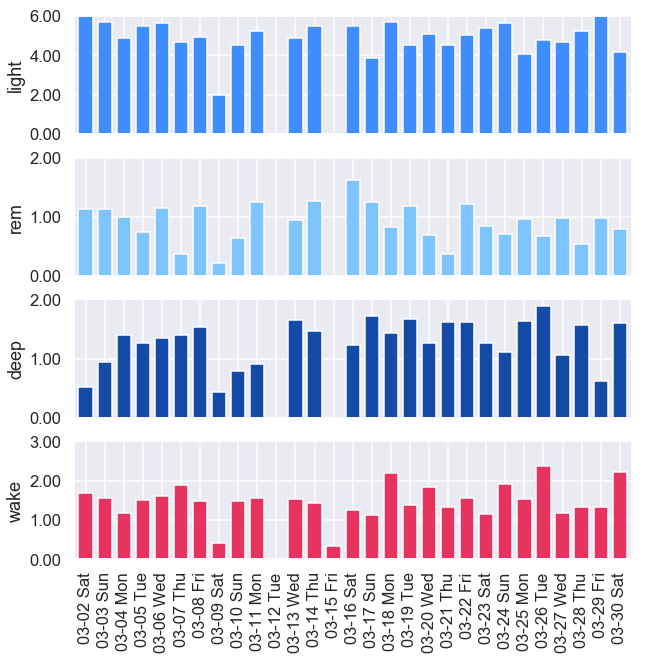

In [13]:
def sleep_report_plots(df, num_days=30, plot_width=None):
    if not plot_width:
        plot_width = num_days*10/30
    data = df[~df['nap']][pd.datetime.today() - pd.Timedelta(num_days, unit='d'):]
    data2 = process_sleeps(data)
    data2dd(data2).sort_index(ascending=False)[['day', 'sleepTime', 'wakeTime', 'hoursInBed', 'hoursAsleep', 'sleep_error', 'deep', 'rem', 'wake']].head(7)
    _ = sleep_inspection_plot(data2, (plot_width,5), xlabels=True)
    _ = sleep_error_plot(data2, (plot_width, 4))
    _ = total_asleep_awake_plot(data2, (plot_width, 3), xlabels=False, legend=False)
    _ = stages_plot(data2, (plot_width, 10), xlabels=False, legend=False)
    
sleep_report_plots(df, 30)

In [14]:
# sleep_report_plots(df, 360)

In [15]:
data2dd(df).sort_index(ascending=False)[['day', 'sleepTime', 'wakeTime', 'hoursInBed', 'hoursAsleep', 'sleep_error', 'deep', 'rem', 'wake', 'awake', 'nap']].head(35)

,day,sleepTime,wakeTime,hoursInBed,hoursAsleep,sleep_error,deep,rem,wake,awake,nap
dateOfSleep,,,,,,,,,,,
2019-03-30,Sat,23:04:00,06:31:00,7.4,6.6,0.07,96.0,48.0,51.0,NaN,False
2019-03-30,Sat,07:28:00,09:35:30,2.1,0.8,8.47,NaN,NaN,NaN,5.0,False
2019-03-29,Fri,22:45:00,07:52:30,9.4,8.0,-0.25,37.0,59.0,80.0,NaN,False
2019-03-28,Thu,23:21:30,07:36:30,8.7,7.3,0.35,94.0,32.0,80.0,NaN,False
2019-03-27,Wed,01:41:00,09:12:00,7.9,6.7,2.68,64.0,59.0,71.0,NaN,False
2019-03-26,Tue,23:31:30,08:49:30,9.7,7.3,0.52,113.0,40.0,143.0,NaN,False
2019-03-25,Mon,22:59:00,06:54:00,8.2,6.6,-0.02,98.0,58.0,92.0,NaN,False
2019-03-24,Sun,22:40:00,07:55:00,9.4,7.4,-0.33,67.0,42.0,115.0,NaN,False
2019-03-23,Sat,14:58:00,15:58:30,1.0,0.6,-8.03,NaN,NaN,NaN,0.0,True


In [ ]:
# plt.figure(figsize=(9, 5))
# ax = plt.gca()
# # _ = data['2019-03':]['levels'].str['data'].apply(lambda x: stage_process(x).apply(lambda x: stages_column_plot(x, ax), axis=1))
# _ = data['2019-01':]['levels'].str['data'].apply(stage_data_column_plot, ax=ax, color_dict=stage_colors)
# _ = plt.xticks(rotation=90)
# ax.axhline(y=23, xmin=0, xmax=20, linestyle='--', color='k', linewidth=2)
# ax.axhline(y=32, xmin=0, xmax=20, linestyle='--', color='k', linewidth=2)


# plt.figure(figsize=(9, 5))
# ax = plt.gca()
# # _ = data['2019-03':]['levels'].str['data'].apply(lambda x: stage_process(x).apply(lambda x: stages_column_plot(x, ax), axis=1))
# _ = data['2019-01':]['levels'].str['data'].apply(stage_data_column_plot, ax=ax, color_dict=green_red_colors)
# _ = plt.xticks(rotation=90)
# ax.axhline(y=23, xmin=0, xmax=20, linestyle='--', color='k', linewidth=2)
# ax.axhline(y=32, xmin=0, xmax=20, linestyle='--', color='k', linewidth=2)